### Стратегия ищет моменты, когда доходность BTC "слишком сильно" отклонилась от своего среднего значения, и делает ставку на возврат к среднему

### Ключевая формула Z-score:
* 1 - Z = (текущая_доходность - средняя_доходность) / стандартное_отклонение, где:
* 2 - текущая_доходность = (цена_сейчас - цена_минуту_назад) / цена_минуту_назад
* 3 - средняя_доходность = среднее за последние 240 минут (4 часа)
* 4 - стандартное_отклонение = волатильность за тот же период, σ = √[(Σ(xi - μ)²) / (n - 1)], где
* xi - каждое значение доходности в скользящем окне
* μ (мю) - среднее арифметическое доходностей в окне
* n - количество наблюдений в окне
* (n - 1) - используется поправка Бесселя для несмещенной оценки

### Пошагово:
* Берется скользящее окно размером lookback_period (по умолчанию 240 минут)
* Для каждого окна вычисляется среднее значение доходностей
* Для каждого значения в окне находится отклонение от среднего, возводится в квадрат
* Все квадраты отклонений суммируются
* Сумма делится на (n-1) - это дисперсия с поправкой Бесселя
* Извлекается квадратный корень - получается стандартное отклонение

### Логика торговли:
#### Вход в позицию (ЛОНГ):
* Когда Z-score ≤ -3.0 (цена упала слишком сильно)
* Покупаем, ожидая отскок вверх

#### Выход из позиции:
* Когда Z-score ≥ 0.0 (цена вернулась к среднему)
* Или стоп-лосс 2% (если цена продолжает падать)

### Простыми словами:
* Если Bitcoin за минуту упал намного сильнее обычного (Z-score < -3), стратегия покупает, рассчитывая что цена "отскочит" обратно к нормальному уровню

=== MEAN-REVERSION СТРАТЕГИЯ ДЛЯ BTCUSDT ===
Период: 2025-01-01 - 2025-06-01
Капитал: $10,000 (с плечом x5: $50,000)
Стоп-лосс: 3.0%
Загрузка данных для BTCUSDT с 2025-01-01 по 2025-06-01...
Загружено 217441 свечей

АНАЛИЗ СТАЦИОНАРНОСТИ

=== Тест стационарности для Доходности ===
ADF Статистика: -60.133964
p-value: 0.000000
Критические значения:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Результат: Ряд стационарен (отвергаем H0)

=== Тест стационарности для Логарифмические доходности ===
ADF Статистика: -60.114789
p-value: 0.000000
Критические значения:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Результат: Ряд стационарен (отвергаем H0)

БАЗОВОЕ БЭКТЕСТИРОВАНИЕ

Результаты базовой стратегии:
----------------------------------------
Общее количество сделок: 500
Процент прибыльных сделок: 68.80%
Общая доходность: 34.74%
Максимальная просадка: -22.21%
Коэффициент Шарпа: 1.76
Profit Factor: 1.19
Финальный капитал: $13,474.42
Средний выигрыш: $64.04
Средний проигрыш: $-119.71

ОПТИМИЗАЦИЯ ПАРАМЕТРОВ



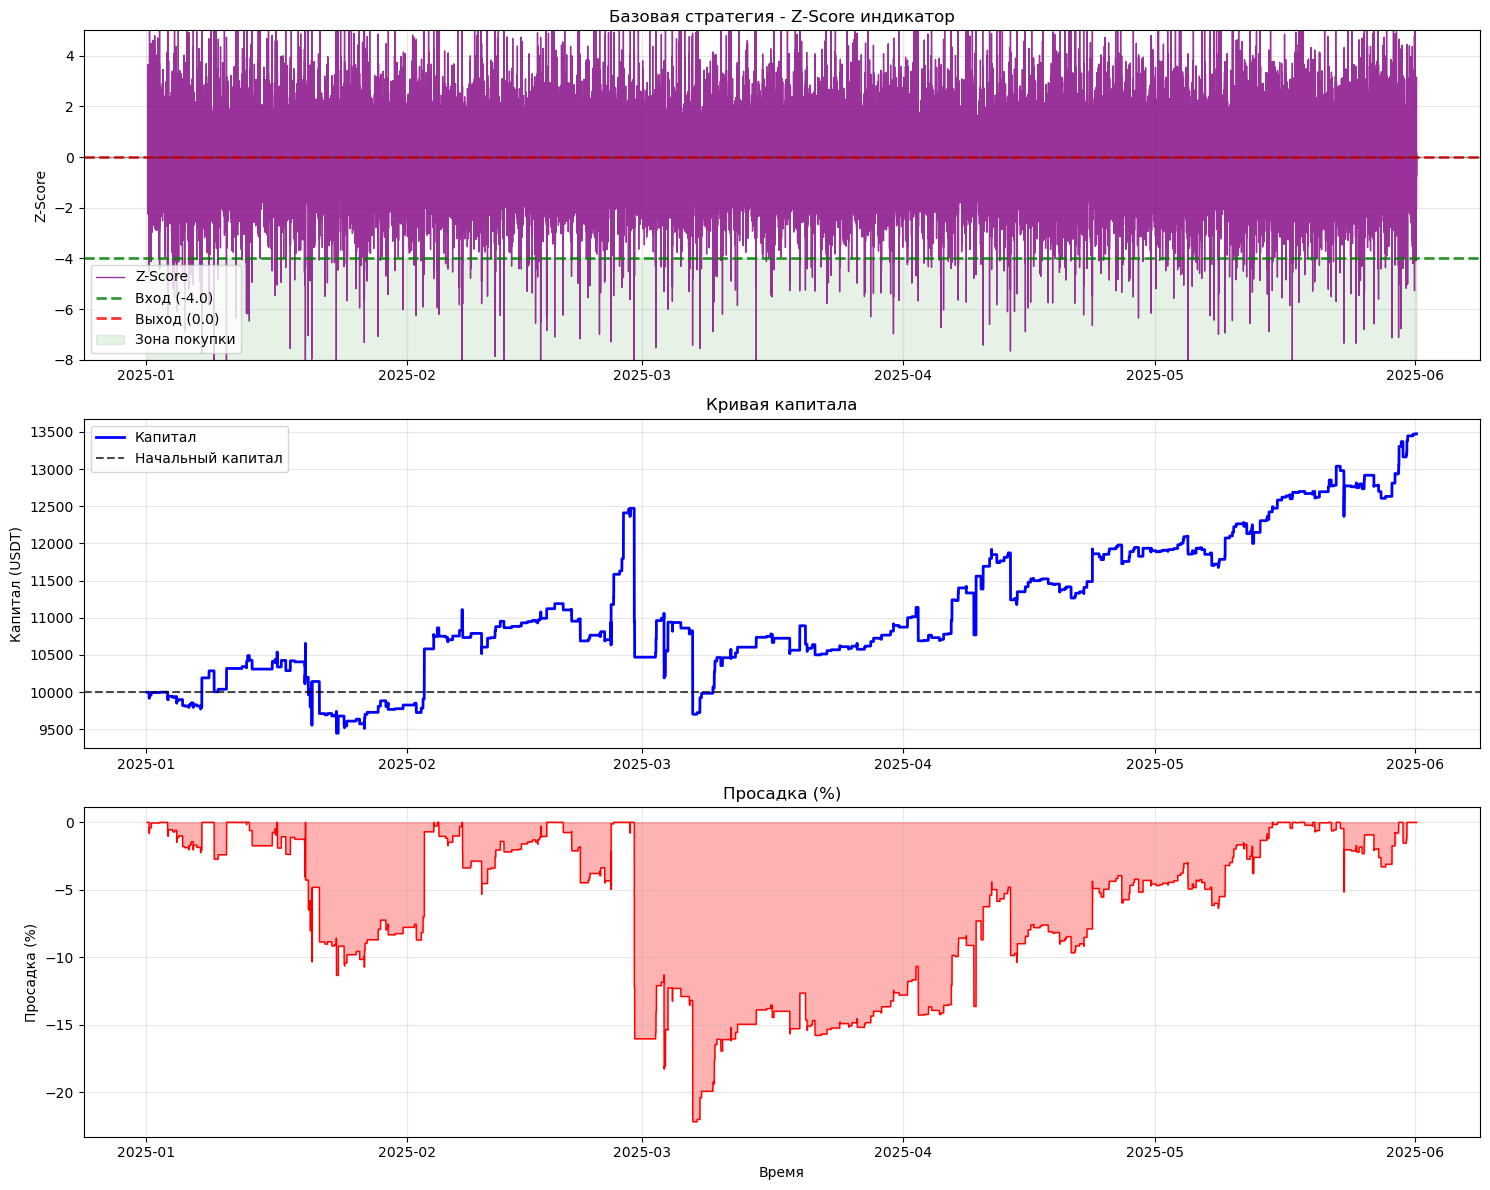


🎯 РЕЗУЛЬТАТЫ ПОСЛЕ ОПТИМИЗАЦИИ


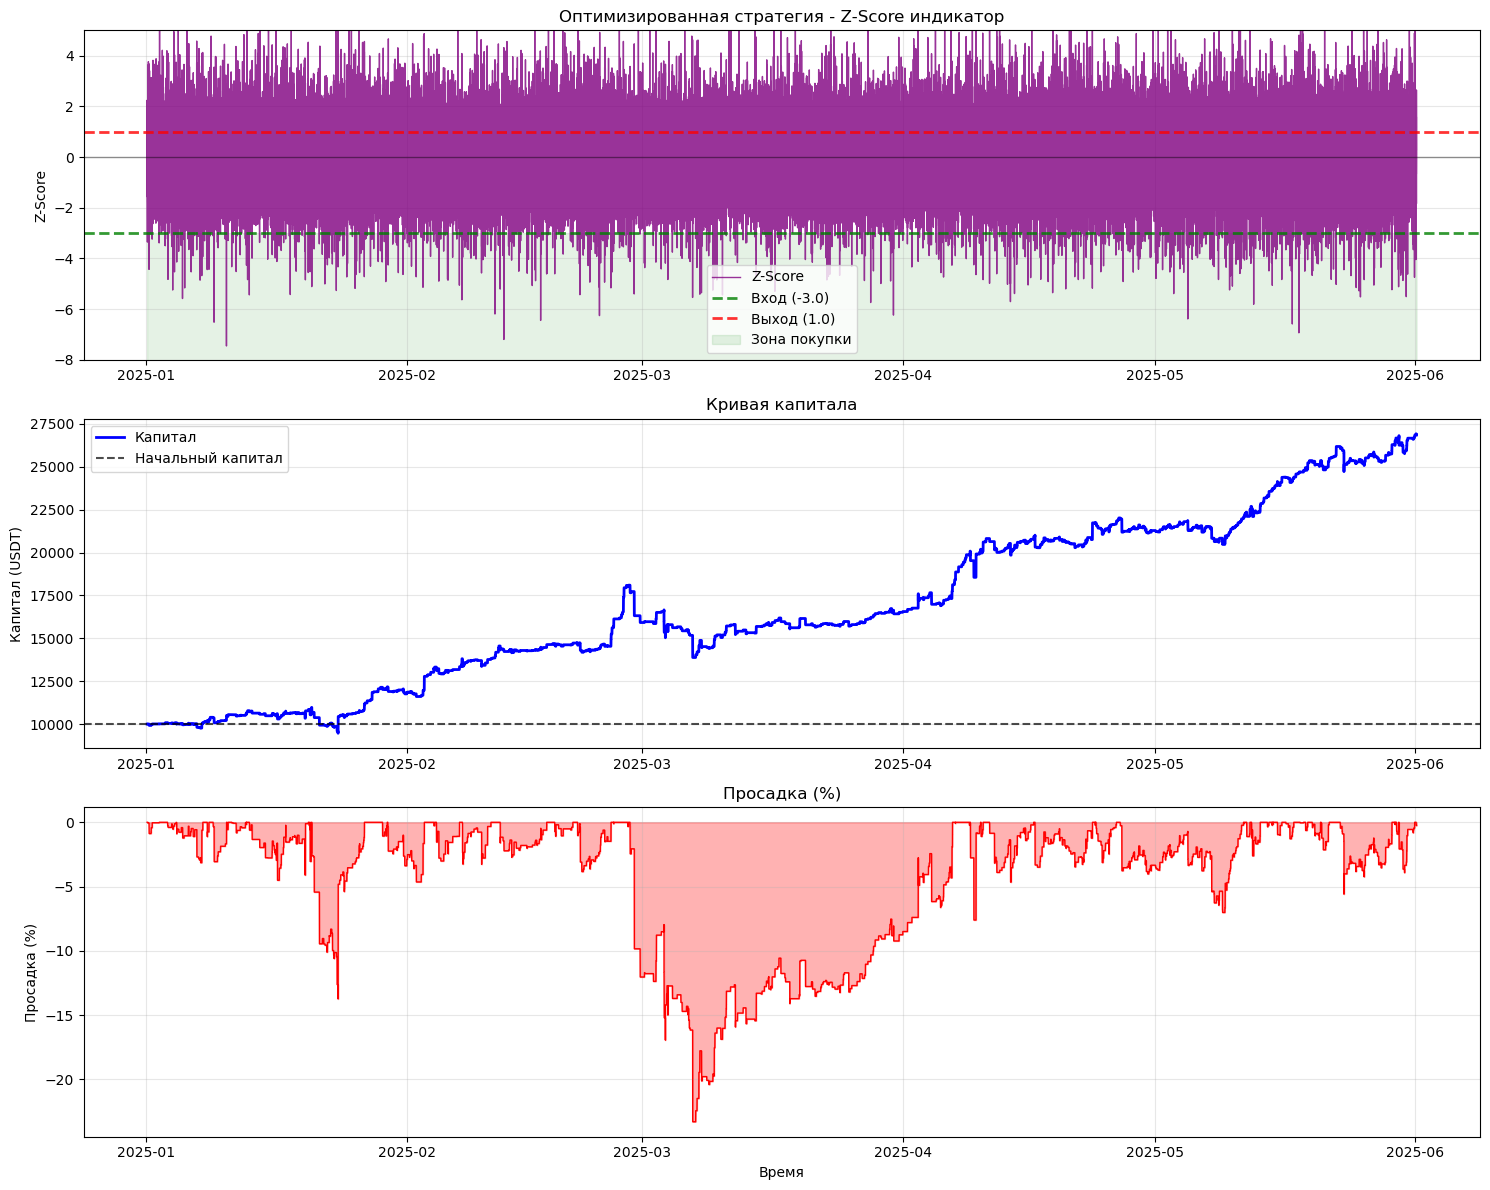


📈 АНАЛИЗ ОПТИМИЗАЦИИ ПАРАМЕТРОВ


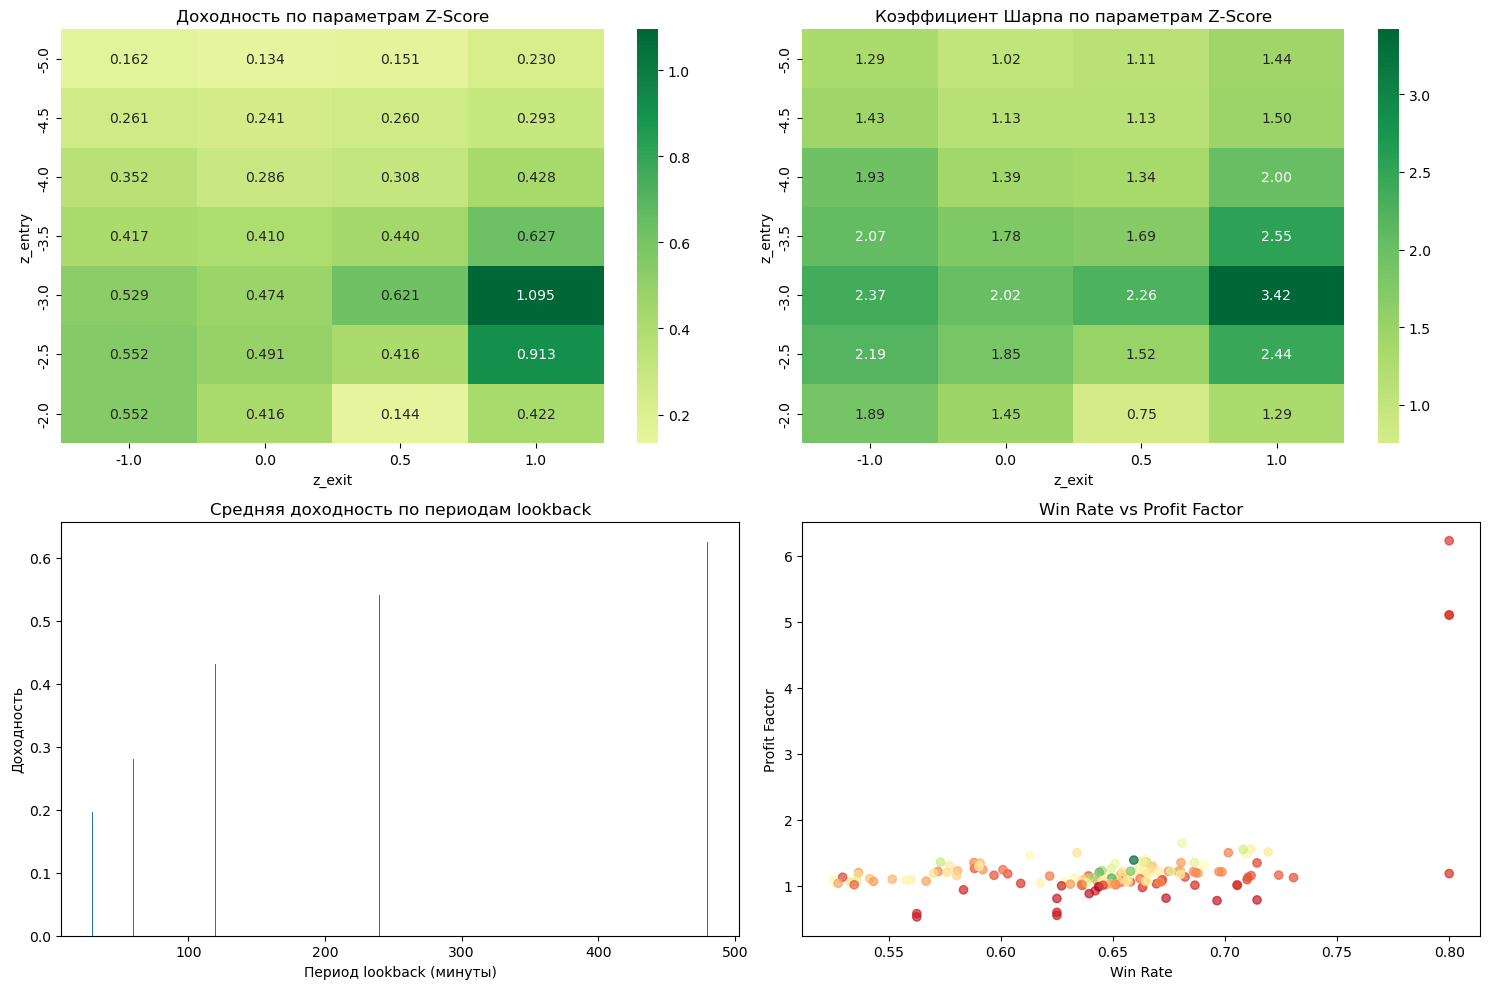


🏆 ТОП-10 ЛУЧШИХ КОМБИНАЦИЙ ПАРАМЕТРОВ
 z_entry  z_exit  lookback  total_return  max_drawdown  sharpe_ratio  win_rate
    -3.0     1.0        60      1.685956     -0.232992      4.784047  0.659319
    -2.5     1.0       480      1.375898     -0.345250      2.857088  0.649457
    -3.0     1.0       240      1.326148     -0.226853      3.422997  0.643856
    -3.0     0.5       240      1.244038     -0.201461      3.541870  0.657876
    -2.5     1.0       120      1.112386     -0.380594      2.840238  0.640833
    -3.0     1.0       120      1.088466     -0.231652      3.395730  0.645025
    -4.0     1.0       480      1.016406     -0.141272      3.700226  0.664940
    -3.0    -1.0        60      0.994220     -0.180052      3.937118  0.573077
    -4.5     0.5       480      0.964446     -0.127625      4.087414  0.708122
    -3.5     0.5       480      0.903932     -0.214620      3.080601  0.675966


In [20]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats
from itertools import product
import time

warnings.filterwarnings('ignore')

# =============================================================================
# ПАРАМЕТРЫ СТРАТЕГИИ
# =============================================================================

# Основные параметры
SYMBOL = 'BTCUSDT'
INTERVAL = '1m'
START_DATE = '2025-01-01'
END_DATE = '2025-06-01'
INITIAL_CAPITAL = 10000
LEVERAGE = 5
TRADING_CAPITAL = INITIAL_CAPITAL * LEVERAGE
STOP_LOSS_PCT = 0.03  # 2% стоп-лосс

# Параметры стратегии для перебора
Z_SCORE_ENTRY_RANGE = [-5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0]  # Пороги входа
Z_SCORE_EXIT_RANGE = [-1, 0.0, 0.5, 1.0]  # Пороги выхода
LOOKBACK_PERIODS = [30, 60, 120, 240, 480]  # Периоды для расчета средней (в минутах)

# Базовые параметры для первичного тестирования
BASE_Z_ENTRY = -4.0
BASE_Z_EXIT = 0.0
BASE_LOOKBACK = 240

# =============================================================================
# ФУНКЦИИ ДЛЯ ЗАГРУЗКИ ДАННЫХ
# =============================================================================

def get_binance_data(symbol, interval, start_date, end_date):
    """Загрузка данных с Binance API"""
    
    # Конвертация дат в timestamp
    start_ts = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp() * 1000)
    end_ts = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp() * 1000)
    
    all_data = []
    current_start = start_ts
    
    print(f"Загрузка данных для {symbol} с {start_date} по {end_date}...")
    
    while current_start < end_ts:
        url = f"https://api.binance.com/api/v3/klines"
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': min(current_start + 1000 * 60 * 1000, end_ts),  # Максимум 1000 свечей
            'limit': 1000
        }
        
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if not data:
                break
                
            all_data.extend(data)
            current_start = data[-1][6] + 1  # Следующий timestamp
            
            # Задержка для избежания лимитов API
            time.sleep(0.1)
            
        except Exception as e:
            print(f"Ошибка при загрузке данных: {e}")
            break
    
    # Создание DataFrame
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    # Конвертация типов данных
    numeric_columns = ['open', 'high', 'low', 'close', 'volume']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col])
    
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('datetime', inplace=True)
    
    print(f"Загружено {len(df)} свечей")
    return df[['open', 'high', 'low', 'close', 'volume']]

# =============================================================================
# ФУНКЦИИ ДЛЯ АНАЛИЗА СТАЦИОНАРНОСТИ
# =============================================================================

def calculate_returns(df):
    """Расчет доходностей"""
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    return df

def test_stationarity(series, name="Series"):
    """Тест на стационарность (ADF тест)"""
    from statsmodels.tsa.stattools import adfuller
    
    # Удаляем NaN значения
    series_clean = series.dropna()
    
    result = adfuller(series_clean)
    
    print(f'\n=== Тест стационарности для {name} ===')
    print(f'ADF Статистика: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Критические значения:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Результат: Ряд стационарен (отвергаем H0)")
        return True
    else:
        print("Результат: Ряд НЕ стационарен (не можем отвергнуть H0)")
        return False

# =============================================================================
# ФУНКЦИИ СТРАТЕГИИ
# =============================================================================

def calculate_z_score(df, lookback_period=240):
    """Расчет Z-score для mean-reversion стратегии"""
    
    # Группировка по дням для расчета дневной статистики
    df['date'] = df.index.date
    
    # Расчет скользящих средних и стандартных отклонений
    df['rolling_mean'] = df['returns'].rolling(window=lookback_period, min_periods=lookback_period//2).mean()
    df['rolling_std'] = df['returns'].rolling(window=lookback_period, min_periods=lookback_period//2).std()
    
    # Расчет Z-score
    df['z_score'] = (df['returns'] - df['rolling_mean']) / df['rolling_std']
    
    return df

def backtest_strategy(df, z_entry=-3.0, z_exit=0.0, lookback_period=240):
    """Бэктестирование mean-reversion стратегии"""
    
    # Копируем данные
    data = df.copy()
    
    # Расчет Z-score
    data = calculate_z_score(data, lookback_period)
    
    # Инициализация переменных
    position = 0  # 0 - нет позиции, 1 - лонг позиция
    entry_price = 0
    trades = []
    equity_curve = [INITIAL_CAPITAL]
    current_capital = INITIAL_CAPITAL
    
    for i in range(1, len(data)):
        current_price = data['close'].iloc[i]
        current_z = data['z_score'].iloc[i]
        
        if pd.isna(current_z):
            equity_curve.append(current_capital)
            continue
        
        # Логика входа в позицию
        if position == 0 and current_z <= z_entry:
            position = 1
            entry_price = current_price
            
        # Логика выхода из позиции
        elif position == 1:
            exit_condition = False
            exit_reason = ""
            
            # Выход по Z-score
            if current_z >= z_exit:
                exit_condition = True
                exit_reason = "z_score_exit"
            
            # Стоп-лосс
            elif (entry_price - current_price) / entry_price >= STOP_LOSS_PCT:
                exit_condition = True
                exit_reason = "stop_loss"
            
            if exit_condition:
                # Расчет результата сделки
                pnl_pct = (current_price - entry_price) / entry_price
                pnl_amount = current_capital * pnl_pct * LEVERAGE
                
                current_capital += pnl_amount
                
                # Записываем сделку
                trades.append({
                    'entry_time': data.index[i-1],
                    'exit_time': data.index[i],
                    'entry_price': entry_price,
                    'exit_price': current_price,
                    'pnl_pct': pnl_pct,
                    'pnl_amount': pnl_amount,
                    'exit_reason': exit_reason,
                    'z_entry': data['z_score'].iloc[i-1],
                    'z_exit': current_z
                })
                
                position = 0
                entry_price = 0
        
        equity_curve.append(current_capital)
    
    # Создание DataFrame с результатами
    results_df = data.copy()
    results_df['equity'] = equity_curve
    
    return results_df, trades

def calculate_performance_metrics(trades, equity_curve):
    """Расчет метрик производительности"""
    
    if not trades:
        return {
            'total_trades': 0,
            'win_rate': 0,
            'total_return': 0,
            'max_drawdown': 0,
            'sharpe_ratio': 0,
            'profit_factor': 0,
            'avg_win': 0,
            'avg_loss': 0
        }
    
    trades_df = pd.DataFrame(trades)
    
    # Основные метрики
    total_trades = len(trades)
    winning_trades = sum(1 for trade in trades if trade['pnl_amount'] > 0)
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    total_return = (equity_curve[-1] - INITIAL_CAPITAL) / INITIAL_CAPITAL
    
    # Максимальная просадка
    equity_series = pd.Series(equity_curve)
    running_max = equity_series.expanding().max()
    drawdown = (equity_series - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Коэффициент Шарпа (упрощенный)
    returns = equity_series.pct_change().dropna()
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(525600) if returns.std() > 0 else 0  # Годовой Шарп
    
    # Profit Factor
    total_wins = sum(trade['pnl_amount'] for trade in trades if trade['pnl_amount'] > 0)
    total_losses = abs(sum(trade['pnl_amount'] for trade in trades if trade['pnl_amount'] < 0))
    profit_factor = total_wins / total_losses if total_losses > 0 else float('inf')
    
    # Средние выигрыши и проигрыши
    wins = [trade['pnl_amount'] for trade in trades if trade['pnl_amount'] > 0]
    losses = [trade['pnl_amount'] for trade in trades if trade['pnl_amount'] < 0]
    
    avg_win = np.mean(wins) if wins else 0
    avg_loss = np.mean(losses) if losses else 0
    
    return {
        'total_trades': total_trades,
        'win_rate': win_rate,
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio,
        'profit_factor': profit_factor,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'final_capital': equity_curve[-1]
    }

# =============================================================================
# ФУНКЦИИ ОПТИМИЗАЦИИ
# =============================================================================

def optimize_parameters(df):
    """Перебор параметров для оптимизации стратегии"""
    
    print("\n=== ОПТИМИЗАЦИЯ ПАРАМЕТРОВ ===")
    
    results = []
    total_combinations = len(Z_SCORE_ENTRY_RANGE) * len(Z_SCORE_EXIT_RANGE) * len(LOOKBACK_PERIODS)
    current_combination = 0
    
    for z_entry, z_exit, lookback in product(Z_SCORE_ENTRY_RANGE, Z_SCORE_EXIT_RANGE, LOOKBACK_PERIODS):
        current_combination += 1
        print(f"Тестирование комбинации {current_combination}/{total_combinations}: "
              f"z_entry={z_entry}, z_exit={z_exit}, lookback={lookback}")
        
        try:
            results_df, trades = backtest_strategy(df, z_entry, z_exit, lookback)
            metrics = calculate_performance_metrics(trades, results_df['equity'].tolist())
            
            result = {
                'z_entry': z_entry,
                'z_exit': z_exit,
                'lookback': lookback,
                **metrics
            }
            results.append(result)
            
        except Exception as e:
            print(f"Ошибка при тестировании параметров {z_entry}, {z_exit}, {lookback}: {e}")
    
    return pd.DataFrame(results)

# =============================================================================
# ФУНКЦИИ ВИЗУАЛИЗАЦИИ
# =============================================================================

def plot_results(df, trades, title="Результаты бэктестирования", z_entry=BASE_Z_ENTRY, z_exit=BASE_Z_EXIT):
    """Визуализация результатов"""
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # График 1: Z-score индикатор
    axes[0].plot(df.index, df['z_score'], label='Z-Score', color='purple', alpha=0.8, linewidth=1)
    axes[0].axhline(y=z_entry, color='green', linestyle='--', alpha=0.8, linewidth=2, label=f'Вход ({z_entry})')
    axes[0].axhline(y=z_exit, color='red', linestyle='--', alpha=0.8, linewidth=2, label=f'Выход ({z_exit})')
    axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.4, linewidth=1)
    axes[0].fill_between(df.index, z_entry, -10, alpha=0.1, color='green', label='Зона покупки')
    axes[0].set_title(f'{title} - Z-Score индикатор')
    axes[0].set_ylabel('Z-Score')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(-8, 5)
    
    # График 2: Кривая капитала
    axes[1].plot(df.index, df['equity'], label='Капитал', color='blue', linewidth=2)
    axes[1].axhline(y=INITIAL_CAPITAL, color='black', linestyle='--', alpha=0.7, label='Начальный капитал')
    axes[1].set_title('Кривая капитала')
    axes[1].set_ylabel('Капитал (USDT)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # График 3: Просадка
    equity_series = pd.Series(df['equity'].values, index=df.index)
    running_max = equity_series.expanding().max()
    drawdown = (equity_series - running_max) / running_max * 100
    
    axes[2].fill_between(df.index, drawdown, 0, alpha=0.3, color='red')
    axes[2].plot(df.index, drawdown, color='red', linewidth=1)
    axes[2].set_title('Просадка (%)')
    axes[2].set_ylabel('Просадка (%)')
    axes[2].set_xlabel('Время')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_optimization_results(opt_results):
    """Визуализация результатов оптимизации"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Тепловая карта доходности
    pivot_return = opt_results.pivot_table(values='total_return', 
                                         index='z_entry', 
                                         columns='z_exit', 
                                         aggfunc='mean')
    
    sns.heatmap(pivot_return, annot=True, fmt='.3f', cmap='RdYlGn', 
                center=0, ax=axes[0,0])
    axes[0,0].set_title('Доходность по параметрам Z-Score')
    
    # Тепловая карта Sharpe Ratio
    pivot_sharpe = opt_results.pivot_table(values='sharpe_ratio', 
                                         index='z_entry', 
                                         columns='z_exit', 
                                         aggfunc='mean')
    
    sns.heatmap(pivot_sharpe, annot=True, fmt='.2f', cmap='RdYlGn', 
                center=0, ax=axes[0,1])
    axes[0,1].set_title('Коэффициент Шарпа по параметрам Z-Score')
    
    # График доходности по периоду lookback
    lookback_stats = opt_results.groupby('lookback').agg({
        'total_return': 'mean',
        'max_drawdown': 'mean',
        'sharpe_ratio': 'mean'
    }).reset_index()
    
    axes[1,0].bar(lookback_stats['lookback'], lookback_stats['total_return'])
    axes[1,0].set_title('Средняя доходность по периодам lookback')
    axes[1,0].set_xlabel('Период lookback (минуты)')
    axes[1,0].set_ylabel('Доходность')
    
    # График Win Rate vs Profit Factor
    axes[1,1].scatter(opt_results['win_rate'], opt_results['profit_factor'], 
                     c=opt_results['total_return'], cmap='RdYlGn', alpha=0.7)
    axes[1,1].set_xlabel('Win Rate')
    axes[1,1].set_ylabel('Profit Factor')
    axes[1,1].set_title('Win Rate vs Profit Factor')
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# ОСНОВНОЙ КОД ВЫПОЛНЕНИЯ
# =============================================================================

def main():
    print("=== MEAN-REVERSION СТРАТЕГИЯ ДЛЯ BTCUSDT ===")
    print(f"Период: {START_DATE} - {END_DATE}")
    print(f"Капитал: ${INITIAL_CAPITAL:,} (с плечом x{LEVERAGE}: ${TRADING_CAPITAL:,})")
    print(f"Стоп-лосс: {STOP_LOSS_PCT*100}%")
    
    # 1. Загрузка данных
    df = get_binance_data(SYMBOL, INTERVAL, START_DATE, END_DATE)
    
    if df.empty:
        print("Не удалось загрузить данные!")
        return
    
    # Расчет доходностей
    df = calculate_returns(df)
    
    # 2. Анализ стационарности
    print("\n" + "="*50)
    print("АНАЛИЗ СТАЦИОНАРНОСТИ")
    print("="*50)
    
    test_stationarity(df['returns'], "Доходности")
    test_stationarity(df['log_returns'], "Логарифмические доходности")
    
    # 3. Базовое бэктестирование
    print("\n" + "="*50)
    print("БАЗОВОЕ БЭКТЕСТИРОВАНИЕ")
    print("="*50)
    
    results_df, trades = backtest_strategy(df, BASE_Z_ENTRY, BASE_Z_EXIT, BASE_LOOKBACK)
    base_metrics = calculate_performance_metrics(trades, results_df['equity'].tolist())
    
    print(f"\nРезультаты базовой стратегии:")
    print("-" * 40)
    print(f"Общее количество сделок: {base_metrics['total_trades']}")
    print(f"Процент прибыльных сделок: {base_metrics['win_rate']:.2%}")
    print(f"Общая доходность: {base_metrics['total_return']:.2%}")
    print(f"Максимальная просадка: {base_metrics['max_drawdown']:.2%}")
    print(f"Коэффициент Шарпа: {base_metrics['sharpe_ratio']:.2f}")
    print(f"Profit Factor: {base_metrics['profit_factor']:.2f}")
    print(f"Финальный капитал: ${base_metrics['final_capital']:,.2f}")
    print(f"Средний выигрыш: ${base_metrics['avg_win']:,.2f}")
    print(f"Средний проигрыш: ${base_metrics['avg_loss']:,.2f}")
    
    # 4. Оптимизация параметров
    print("\n" + "="*50)
    print("ОПТИМИЗАЦИЯ ПАРАМЕТРОВ")
    print("="*50)
    
    opt_results = optimize_parameters(df)
    
    # Находим лучшие параметры
    best_params = opt_results.loc[opt_results['total_return'].idxmax()]
    
    print(f"\nЛучшие параметры после оптимизации:")
    print("-" * 45)
    print(f"Z-Score вход: {best_params['z_entry']}")
    print(f"Z-Score выход: {best_params['z_exit']}")
    print(f"Период lookback: {best_params['lookback']} минут")
    print(f"Общее количество сделок: {int(best_params['total_trades'])}")
    print(f"Процент прибыльных сделок: {best_params['win_rate']:.2%}")
    print(f"Доходность: {best_params['total_return']:.2%}")
    print(f"Максимальная просадка: {best_params['max_drawdown']:.2%}")
    print(f"Коэффициент Шарпа: {best_params['sharpe_ratio']:.2f}")
    print(f"Profit Factor: {best_params['profit_factor']:.2f}")
    print(f"Финальный капитал: ${best_params['final_capital']:,.2f}")
    print(f"Средний выигрыш: ${best_params['avg_win']:,.2f}")
    print(f"Средний проигрыш: ${best_params['avg_loss']:,.2f}")
    
    # 5. Бэктестирование с лучшими параметрами
    print("\n" + "="*50)
    print("БЭКТЕСТИРОВАНИЕ С ОПТИМАЛЬНЫМИ ПАРАМЕТРАМИ")
    print("="*50)
    
    best_results_df, best_trades = backtest_strategy(
        df, 
        best_params['z_entry'], 
        best_params['z_exit'], 
        int(best_params['lookback'])
    )
    
    # 6. Визуализация результатов
    print("\n" + "="*70)
    print("📊 РЕЗУЛЬТАТЫ БАЗОВОЙ СТРАТЕГИИ")
    print("="*70)
    
    # График базовой стратегии
    plot_results(results_df, trades, "Базовая стратегия", BASE_Z_ENTRY, BASE_Z_EXIT)
    
    print("\n" + "="*70)
    print("🎯 РЕЗУЛЬТАТЫ ПОСЛЕ ОПТИМИЗАЦИИ")
    print("="*70)
    
    # График оптимизированной стратегии
    plot_results(best_results_df, best_trades, "Оптимизированная стратегия", 
                best_params['z_entry'], best_params['z_exit'])
    
    print("\n" + "="*70)
    print("📈 АНАЛИЗ ОПТИМИЗАЦИИ ПАРАМЕТРОВ")
    print("="*70)
    
    # График результатов оптимизации
    plot_optimization_results(opt_results)
    
    print("\n" + "="*70)
    print("🏆 ТОП-10 ЛУЧШИХ КОМБИНАЦИЙ ПАРАМЕТРОВ")
    print("="*70)
    top_results = opt_results.nlargest(10, 'total_return')[
        ['z_entry', 'z_exit', 'lookback', 'total_return', 'max_drawdown', 'sharpe_ratio', 'win_rate']
    ]
    print(top_results.to_string(index=False))
    
    return df, results_df, best_results_df, opt_results

if __name__ == "__main__":
    # Запуск основной функции
    df, results_df, best_results_df, opt_results = main()